# Discourse Network creation

This file describes how a network can be generated from the discourse data obtained from the scrapper

In [1]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from networkx.algorithms import bipartite
import community as community_louvain

## Define our network and feed it the data
First we are defining our network instance and we feed it the data that the scrapper has grabbed from the online instance

In [2]:
G = nx.MultiDiGraph()

In [3]:
with open('./results/users.json') as f:
    users = json.load(f)

In [4]:
# The reason why we here do not follow the naming convention of type_id is because 
# the objects are using the username as an id for users so, instead of holding in memory a table of 
# username to ids, we are going to use usernames 
for user in users:
    G.add_node(user['user']['username'], node_type="user", data=user)
    
G.add_node("system", node_type="user", data={
    'id': -1,
    'time_read': 0,
    'likes_received': 0,
    'likes_given': 0,
    'topics_entered': 0,
    'topic_count': 0,
    'post_count': 0,
    'posts_read': 0,
    'days_visited': 0,
    'user': {
        'username': 'system',
        'name': 'system',
        'avatar_template': '',
        'post_url': None,
    }
})    

In [5]:
topic_files = os.listdir('./results/categories/')

In [6]:
for topic_file in topic_files:
    with open('./results/categories/'+topic_file) as f:
        category = json.load(f) 
    data = [category[k] for k in category if k not in ['topipcs', 'posts']]
    G.add_node("category_{}".format(category['id']), node_type="category", data=data)
    for topic in category['topics']:
        G.add_node("topic_{}".format(topic['id']), node_type="topic", data=topic)
        G.add_edge("topic_{}".format(topic['id']), "category_{}".format(category['id']), edge_type="is_part_of")
    for topic_id in category['posts']:
        for post in category['posts'][topic_id]['post_stream']['posts']:
            G.add_node("post_{}".format(post['id']), node_type="post", data=post)
            G.add_edge("post_{}".format(post['id']), "topic_{}".format(topic_id), edge_type="is_part_of")
            G.add_edge(post['username'], "post_{}".format(post['id']), edge_type="is_author_of")
            if post['reply_to_post_number']:
                G.add_edge(post['username'], "post_{}".format(post['id']), edge_type="replied_to")
        for post_id in category['posts'][topic_id]['likes']:
            for user in category['posts'][topic_id]['likes'][post_id]['post_action_users']:
                G.add_edge(user['username'], "post_{}".format(post_id), edge_type="liked")

## Example of how to use the network
Here are some example on how to use the network 

First let's extract the different types of nodes for ease of use

In [7]:
categories = [n for n in G.nodes() if G.nodes[n]['node_type'] == "category"]
topics = [n for n in G.nodes() if G.nodes[n]['node_type'] == "topic"]
posts = [n for n in G.nodes() if G.nodes[n]['node_type'] == "post"]
users = [n for n in G.nodes() if G.nodes[n]['node_type'] == "user"]

### Projection of User Graph based on posts
This is the User interaction graph based on posts, where we project the interaction between all users on all posts

In [8]:
# lets remove all users that have a degree 0, aka we don't have any information on them
print("before:", len(users))
degrees = nx.degree(G)
users = [user for user in users if degrees[user] > 0]
print("after:", len(users))

before: 348
after: 52


In [9]:
# From https://stackoverflow.com/questions/3931541/how-to-check-if-all-of-the-following-items-are-in-a-list
def is_subseq(v2, v1):
    """Check whether v2 is a subsequence of v1."""
    it = iter(v1)
    return all(c in it for c in v2) 
# Testing
a = [1, 2, 3, 4, 5]
b = [2, 3, 4]
assert(is_subseq(b, a) == True)
assert(is_subseq(a, b) == False)

In [10]:
# We can do a projection between users using a path test in the network, it is less efficient that a projection, but is nonetheless usefull and 
# multipartite graph projections are not implemented in networkx
usersG = nx.Graph()
# We need to simplify the multiGraph onto a Graph 
sG = nx.Graph(G)
# We also want to remove the categories as a source of edge, else everyone will be connected
sG = nx.subgraph(sG, users+posts+topics)
# Finally we have to make a bit of a crazy algorithm but its not too bad
illegal = ["post", "user", "post"]
for userA in users:
    for userB in users:
        if userA != userB:
            try: # This is because networkx raises if no path exists instead of saying None -_-
                path = nx.shortest_path(sG, userA, userB)
                path_types = [sG.nodes[node]['node_type'] for node in path]
                if not is_subseq(illegal, path_types):
                    if usersG.has_edge(userA, userB):
                        usersG[userA][userB]["weight"] +=1
                    else:
                        usersG.add_edge(userA, userB, weight=1)
            except:
                pass

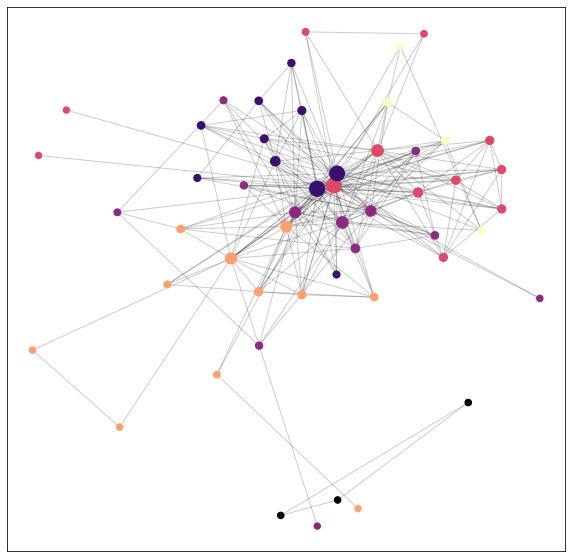

In [11]:
fig = plt.figure(figsize=(10,10))
# Compute position of nodes
pos = nx.spring_layout(usersG, k=0.9)
# And metadata
degrees = nx.degree(usersG)
sizes = [(degrees[node]**1.5)+40 for node in usersG.nodes()]
partition = community_louvain.best_partition(usersG)
cmap = cm.get_cmap('magma', max(partition.values()) + 1)

# Not useful here cause all weights are 2 or 1
# weights = [edge[2]['weight'] for edge in usersG.edges(data=True)]
# cmapWeight = cm.get_cmap('cividis', max(weights) + 1)

nx.draw_networkx_nodes(usersG, pos=pos, node_size=sizes, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(usersG, pos=pos, alpha=0.2)
# nx.draw_networkx_edges(usersG, pos=pos, cmap=cmapWeight, edge_color=weights)

#### Selecting just one category

In [39]:
categories

['category_58', 'category_12']

In [40]:
category = 'category_58'

In [41]:
# We can do a projection between users using a path test in the network, it is less efficient that a projection, but is nonetheless usefull and 
# multipartite graph projections are not implemented in networkx
usersG = nx.Graph()
# We need to simplify the multiGraph onto a Graph 
sG = nx.Graph(G)
# This time we want to filter only one category, so  every element that is a child of this we keep
# important is the fact that we project to a DiGraph as we now that we built the MultiDiGraph above going from user upwards
sG = nx.subgraph(sG, nx.ancestors(nx.DiGraph(G), category))
# Finally we have to make a bit of a crazy algorithm but its not too bad
illegal = ["post", "user", "post"]
for userA in users:
    for userB in users:
        if userA != userB:
            try: # This is because networkx raises if no path exists instead of saying None -_-
                path = nx.shortest_path(sG, userA, userB)
                path_types = [sG.nodes[node]['node_type'] for node in path]
                if not is_subseq(illegal, path_types):
                    if usersG.has_edge(userA, userB):
                        usersG[userA][userB]["weight"] +=1
                    else:
                        usersG.add_edge(userA, userB, weight=1)
            except:
                pass

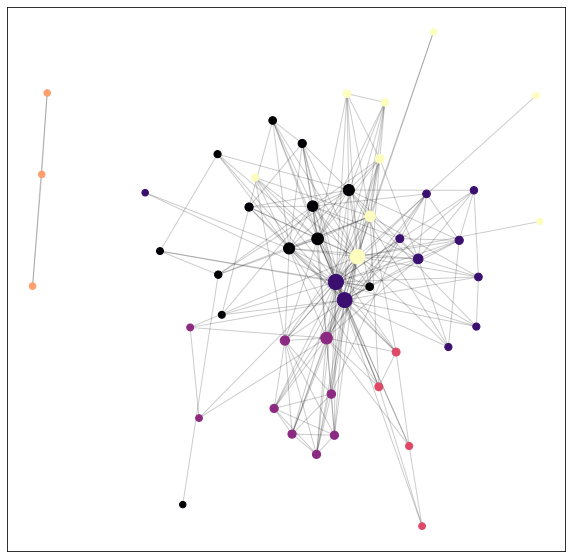

In [43]:
fig = plt.figure(figsize=(10,10))
# Compute position of nodes
pos = nx.spring_layout(usersG, k=0.9)
# And metadata
degrees = nx.degree(usersG)
sizes = [(degrees[node]**1.5)+40 for node in usersG.nodes()]
partition = community_louvain.best_partition(usersG)
cmap = cm.get_cmap('magma', max(partition.values()) + 1)

# Not useful here cause all weights are 2 or 1
# weights = [edge[2]['weight'] for edge in usersG.edges(data=True)]
# cmapWeight = cm.get_cmap('cividis', max(weights) + 1)

nx.draw_networkx_nodes(usersG, pos=pos, node_size=sizes, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(usersG, pos=pos, alpha=0.2)
# nx.draw_networkx_edges(usersG, pos=pos, cmap=cmapWeight, edge_color=weights)